In [1]:
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Import packages that will be used
import c2qa
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RGate

## Example 1: Prepare code words

#### 1A: Prepare cat state

In [5]:
# To prepare a cat state, we first set our initial parameters: we need one qumode and one ancillary qubit. We will also
# need to set a cutoff for our qumode.
Nmodes=1
Nqubits = 1
cutoff = 2**4 # The photon number at which to truncate the Hilbert space. Our basis will consist of Fock states |0> to |cutoff-1>
alpha = 3/np.sqrt(2)

# Instantiate the Qumode register
qmr = c2qa.QumodeRegister(num_qumodes=Nmodes, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))

# Instantiate a Qubit and Classical register
qbr = QuantumRegister(Nqubits)
cbr = ClassicalRegister(Nqubits)

# Initialize a CVCircuit, which includes both the qumode register as well as the qubit register
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

# Compose cat state prep circuit
circuit.h(qbr[0])
circuit.cv_c_d(alpha,qmr[0],qbr[0])
circuit.h(qbr[0])
circuit.measure(qbr[0],cbr[0])

# Now draw the circuit using Qiskit's draw() function
# circuit.draw(scale=1, output = 'mpl', fold = 32, filename = 'figures/Catcircuit.png')

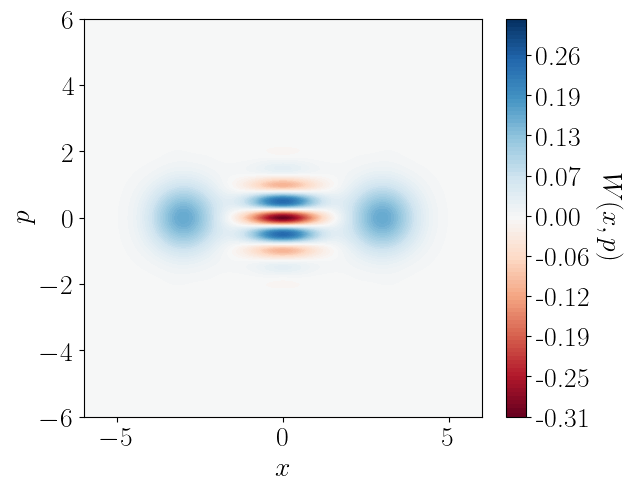

In [6]:
# Now simulate the circuit to retrieve the final density matrix.
stateop, _ = c2qa.util.simulate(circuit)

# Use Bosonic Qiskit's built-in plot_wigner function, which traces out the qubit and displays the Wigner (phase-space) 
# representation of the qumode state.
fig = c2qa.wigner.plot_wigner(circuit,stateop,file='figures/Catstate.png', dpi = 300)

In [7]:
# We can also print out the occupancy of the modes and their complex amplitudes.
c2qa.util.stateread(stateop,1,1,cutoff);

qumodes:  1  qubits:  1     with amplitude: 0.316 - i0.000 (big endian)
qumodes:  3  qubits:  1     with amplitude: 0.581 - i0.000 (big endian)
qumodes:  5  qubits:  1     with amplitude: 0.585 - i0.000 (big endian)
qumodes:  7  qubits:  1     with amplitude: 0.406 - i0.000 (big endian)
qumodes:  9  qubits:  1     with amplitude: 0.215 - i0.000 (big endian)
qumodes:  11  qubits:  1     with amplitude: 0.092 - i0.000 (big endian)
qumodes:  13  qubits:  1     with amplitude: 0.034 - i0.000 (big endian)
qumodes:  15  qubits:  1     with amplitude: 0.013 - i0.000 (big endian)


#### 1B: Prepare GKP code word

In [8]:
# Let's first import the GKP parameters
GKP_params = np.load('GKP_params.npz')

# Set some initial parameters:
Nmodes=1 # The number of qumodes
Nqubits = 1 # The number of qubits
cutoff = 2**5 # The qumode cutoff

# Instantiate the Qumode register
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))

# Instantiate a Qubit register
qbr = QuantumRegister(Nqubits)

# Initialize a CVCircuit, which includes both the qumode register as well as the qubit register
circuit = c2qa.CVCircuit(qmr, qbr)

# Now append gates to the circuit. Here, we append multiple layers, each with a single qubit RGate, followed by
# a conditional displacement and an X gate (which together form the "echoed-conditional displacement" -- for more info,
# see https://www.nature.com/articles/s41567-022-01776-9.
for beta, phi, theta in zip(GKP_params['betas'], GKP_params['phis'], GKP_params['thetas']):
    circuit.append(RGate(theta,phi),[qbr[0]])
    circuit.cv_c_d(beta/2,qmr[0],qbr[0])
    circuit.x(qbr[0])
    
# Now draw the circuit using Qiskit's draw() function
# circuit.draw(scale=0.6, output = 'mpl', fold = 32, filename = 'figures/GKPcircuit.png')

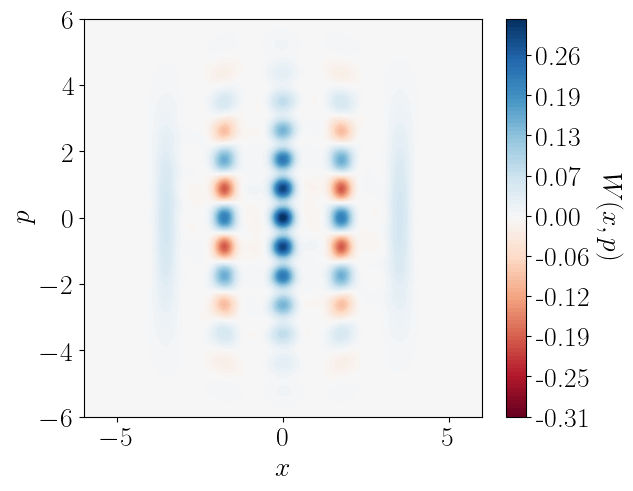

In [9]:
# Now simulate the circuit to retrieve the final density matrix.
stateop, _ = c2qa.util.simulate(circuit)

# Use Bosonic Qiskit's built-in plot_wigner function, which traces out the qubit and displays the Wigner (phase-space) 
# representation of the qumode state.
fig = c2qa.wigner.plot_wigner(circuit,stateop,file='figures/GKPstate.png', dpi = 300)

## Example 2: Simulate the Bose-Hubbard model

In [10]:
# Let's first define a function which constructs our approximation to e^{-iH*dt}
def createU2U1(Nsites,Nbosons, cutoff, U, J, dt):
    from qiskit.converters import circuit_to_gate
    from qiskit.circuit import Parameter
    
    qmr = c2qa.QumodeRegister(num_qumodes=Nsites, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))
    circuit = c2qa.CVCircuit(qmr)

    # First apply U1: Apply beamsplitters in brickwork layout
    theta = -J*dt
    for i in range(0,len(qmr)-1,2):
        circuit.cv_bs(-theta,qmr[i],qmr[i+1])
    for i in range(1,len(qmr)-1,2):
        circuit.cv_bs(-theta,qmr[i],qmr[i+1])
        
    # Now apply U2: Use SNAP gate for each site and Fock state
    theta = (U/2)*dt
    for i in range(0,len(qmr)): # For each site
        for n in range(2,cutoff): # For each Fock state
            circuit.cv_snap(-theta*n*(n-1),n,qmr[i]) # Apply SNAP with phase proportional to n*(n-1)
            
    return circuit_to_gate(circuit,label = 'U2 U1')

In [136]:
# Let's simulate a Bose-Hubbard model with Nsites for the simple case where we have Nbosons loaded into the lattice
Nsites = 4
Nbosons = 4
cutoff = Nbosons + 1

# Initialize the qumode register
qmr = c2qa.QumodeRegister(num_qumodes=Nsites, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))
circuit = c2qa.CVCircuit(qmr)

# Choose parameters
J = 1
U = 0.1
dt = 0.2
t_array = np.arange(0,13*dt,dt)

# Create U2U1, which carries out a single time step of length dt
U2U1 = createU2U1(Nsites, Nbosons, cutoff, U, J, dt)

# Initialize the left-most and right-most mode to each have two bosons initially
circuit.cv_initialize(2, qmr[0])
circuit.cv_initialize(2, qmr[3])

# Loop through each time step and simulate
occupancy_list = np.zeros((len(t_array),Nsites))
for i in range(0,len(t_array)):
    print('Timestep ' + str(int(i+1)) + '/' + str(len(t_array)))
    circuit.append(U2U1,qmr[:])
    stateop,_ = c2qa.util.simulate(circuit)
    
    # Print out occupancy
    occupancy, _ = c2qa.util.stateread(stateop, 0, Nsites, cutoff, verbose=False,little_endian=True)
    occupancy_list[i,:]=np.array(occupancy[0])
    
    
occupancy_largeJ = occupancy_list

Timestep 1/13
Timestep 2/13
Timestep 3/13
Timestep 4/13
Timestep 5/13
Timestep 6/13
Timestep 7/13
Timestep 8/13
Timestep 9/13
Timestep 10/13
Timestep 11/13
Timestep 12/13
Timestep 13/13


<Figure size 432x216 with 0 Axes>

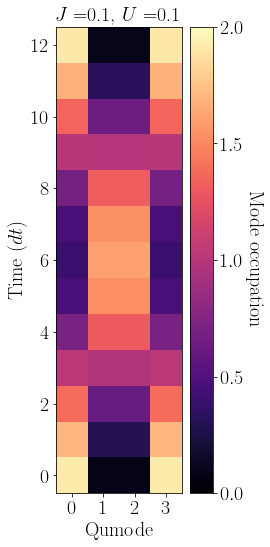

In [98]:
plt.set_cmap("magma")

fig = plt.figure(figsize = (4,8))
plt.pcolormesh([0,1,2,3],np.arange(0,len(t_array)),occupancy_largeJ,linewidth=0,rasterized=True,shading='auto')
plt.title("$J=$" + str(J) + ", $U=$" + str(0.1))
plt.xticks([0,1,2,3])
plt.xlabel("Qumode")
plt.ylabel("Time ($dt$)")
plt.clim(0,2)

cbar = plt.colorbar(pcolor,orientation='vertical',ax=plt.gca())
cbar.ax.get_yaxis().labelpad = 20
cbar.set_ticks([0,0.5,1,1.5,2])
cbar.set_label("Mode occupation", rotation=270)
plt.tight_layout()

## Example 3: Amplitude damping

Let's now illustrate how to include amplitude damping (i.e., photon-loss) in a Bosonic Qiskit simulation. In addition,
we will also demonstrate how to use the built-in wigner distribution animation functionality.

In particular, we will model an oscillator under a linear drive (by acting with a displacement gate) concurrent with the photon-loss noise channel. 

/Users/kevinsmith/Documents/GitHub/c2qa-qiskit/c2qa/kraus.py:171: UserWarning: PhotonLossNoisePass ignores instructions without duration, you may need to schedule circuit in advance.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


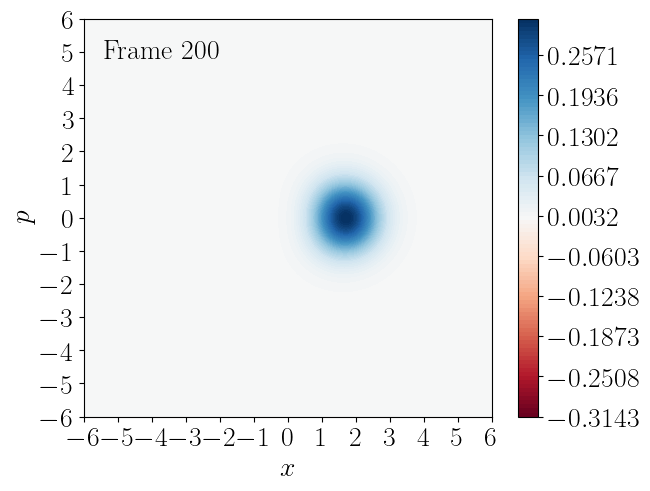

In [6]:
# As usual, first define how many qumodes we want, and how many qubits we should use to represent each (equivalent to choosing a cutoff)
num_qumodes = 1
num_qubits_per_qumode = 4
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
circuit = c2qa.CVCircuit(qmr)

# First initialize the qumode in Fock state |3>
circuit.cv_initialize(3, qmr[0])

# Let's now apply a displacement gate. Bosonic Qiskit allows a user to specify the gate duration in user-specified units (which
# will be used to calculate the loss probability at each time step). Let's go with a 100ns gate duration.
circuit.cv_d(1.5, qmr[0], duration=100, unit="ns")

# Now set a loss rate -- make it large enough such that we can actually see the loss
photon_loss_rate = 0.02 # This is a loss rate in units of 1/ns
time_unit = "ns"
noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit=time_unit)

# The noise pass can then be passed into simulate
state, result = c2qa.util.simulate(circuit, noise_passes=noise_pass)

# Alternatively, we can animate our circuit using the animate_wigner() function built-into bosonic qiskit.
wigner_filename = "figures/photon_loss.mp4"
c2qa.animate.animate_wigner(
    circuit,
    animation_segments=200,
    file=wigner_filename,
    noise_passes=noise_pass
)   